In [1]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 39.9 MB/s eta 0:00:00


In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [3]:

n_layers = 1
n_train = 2000
n_test = 400

np.random.seed(0)
tf.random.set_seed(0)

In [4]:
#load fashion mnist dataset

fashion_mnist_dataset = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist_dataset.load_data()

#reduce size, normalize and add extra dimension for convolution channels
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]
train_images = train_images / 255
test_images = test_images / 255
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

4422102/4422102 [==============================] - 0s 0us/step


In [5]:
#quantum circuit as a convolutional kernel
#system of 4 qubits

dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [6]:
#convolution function

def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [ ]:
#quantum preprocessing layer
q_train_images = []
#quantum preprocessing of train images
for img in train_images:
  q_train_images.append(quanv(img))
q_train_images = np.asarray(q_train_images)

q_test_images = []
#quantum preprocessing of test images
for img in test_images:
  q_test_images.append(quanv(img))

q_test_images = np.asarray(q_test_images)

In [ ]:
np.save('q_train_images.npy', q_train_images)
np.save('q_test_images.npy', q_test_images)

In [9]:
#if already saved

q_train_images = np.random.rand(2000, 14, 14, 4)
q_test_images = np.random.rand(400, 14, 14, 4)
q_train_images= q_train_images.reshape((2000, 14, 14, 4))
q_test_images = q_test_images.reshape((400, 14, 14, 4))

In [10]:

q_train_images = np.load('q_train_images.npy')

q_test_images = np.load('q_test_images.npy')

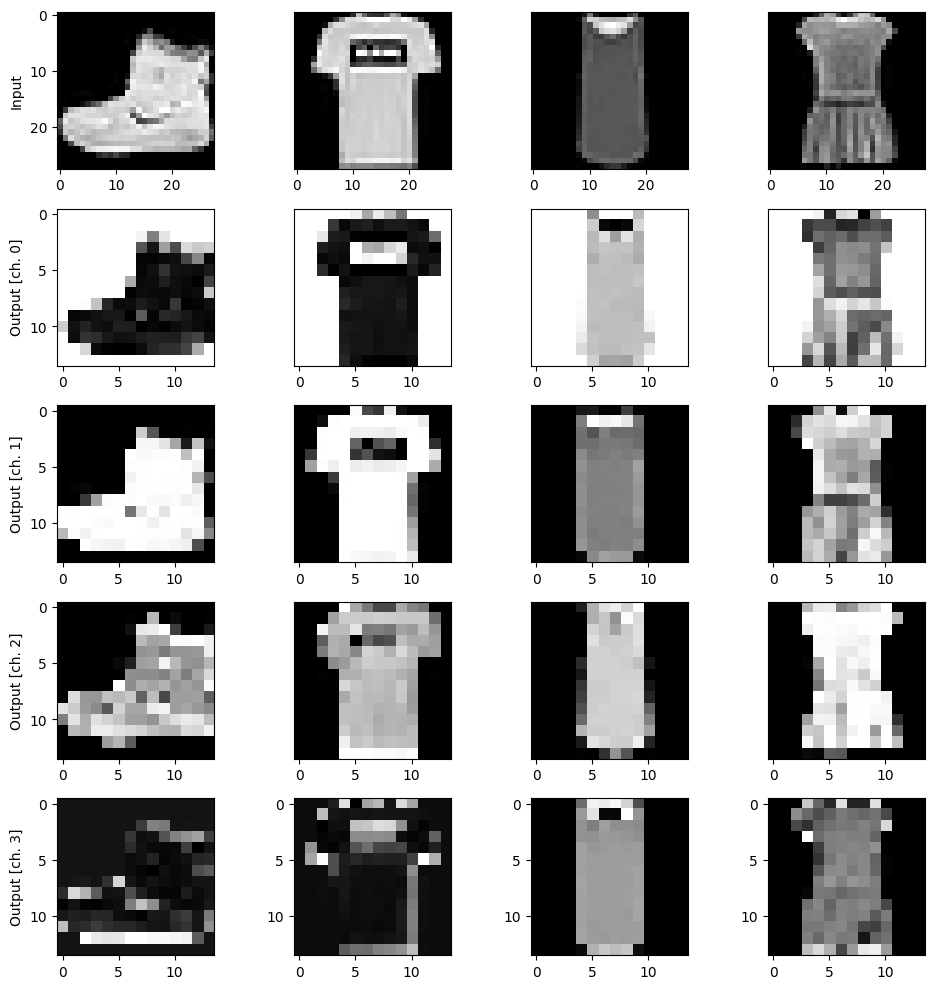

In [11]:
#effect of quantum convolution layer on samples

n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [18]:
def MyQuantumModel():
    model = keras.models.Sequential([
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(14, 14, 4)),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [22]:
#quantum

q_model = MyQuantumModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=32,
    epochs=15,
    verbose=2,
)



Epoch 1/15
63/63 - 4s - loss: 1.2937 - accuracy: 0.5590 - val_loss: 0.8206 - val_accuracy: 0.6875 - 4s/epoch - 60ms/step
Epoch 2/15
63/63 - 1s - loss: 0.6829 - accuracy: 0.7525 - val_loss: 0.6297 - val_accuracy: 0.7650 - 1s/epoch - 19ms/step
Epoch 3/15
63/63 - 1s - loss: 0.5641 - accuracy: 0.7885 - val_loss: 0.5538 - val_accuracy: 0.7825 - 1s/epoch - 20ms/step
Epoch 4/15
63/63 - 2s - loss: 0.4978 - accuracy: 0.8155 - val_loss: 0.5253 - val_accuracy: 0.7950 - 2s/epoch - 35ms/step
Epoch 5/15
63/63 - 1s - loss: 0.4460 - accuracy: 0.8485 - val_loss: 0.5082 - val_accuracy: 0.8075 - 1s/epoch - 18ms/step
Epoch 6/15
63/63 - 1s - loss: 0.4260 - accuracy: 0.8405 - val_loss: 0.5038 - val_accuracy: 0.8250 - 891ms/epoch - 14ms/step
Epoch 7/15
63/63 - 1s - loss: 0.3777 - accuracy: 0.8530 - val_loss: 0.5123 - val_accuracy: 0.8275 - 692ms/epoch - 11ms/step
Epoch 8/15
63/63 - 1s - loss: 0.3282 - accuracy: 0.8865 - val_loss: 0.4771 - val_accuracy: 0.8200 - 652ms/epoch - 10ms/step
Epoch 9/15
63/63 - 1s -

In [20]:
def MyClassicalModel():
    model = keras.models.Sequential([
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [23]:
#classic model
c_model = MyClassicalModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=32,
    epochs=15,
    verbose=2,
)

Epoch 1/15
63/63 - 8s - loss: 1.1554 - accuracy: 0.6050 - val_loss: 0.7450 - val_accuracy: 0.7400 - 8s/epoch - 127ms/step
Epoch 2/15
63/63 - 7s - loss: 0.6291 - accuracy: 0.7745 - val_loss: 0.5715 - val_accuracy: 0.7900 - 7s/epoch - 106ms/step
Epoch 3/15
63/63 - 4s - loss: 0.5278 - accuracy: 0.8110 - val_loss: 0.4951 - val_accuracy: 0.8225 - 4s/epoch - 70ms/step
Epoch 4/15
63/63 - 3s - loss: 0.4623 - accuracy: 0.8275 - val_loss: 0.4813 - val_accuracy: 0.8375 - 3s/epoch - 40ms/step
Epoch 5/15
63/63 - 4s - loss: 0.4150 - accuracy: 0.8440 - val_loss: 0.4646 - val_accuracy: 0.8425 - 4s/epoch - 58ms/step
Epoch 6/15
63/63 - 3s - loss: 0.3906 - accuracy: 0.8560 - val_loss: 0.4933 - val_accuracy: 0.8200 - 3s/epoch - 52ms/step
Epoch 7/15
63/63 - 3s - loss: 0.3556 - accuracy: 0.8700 - val_loss: 0.4915 - val_accuracy: 0.8125 - 3s/epoch - 43ms/step
Epoch 8/15
63/63 - 3s - loss: 0.3185 - accuracy: 0.8825 - val_loss: 0.4688 - val_accuracy: 0.8500 - 3s/epoch - 44ms/step
Epoch 9/15
63/63 - 3s - loss: 

<ipython-input-25-8eea056e7d0a>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


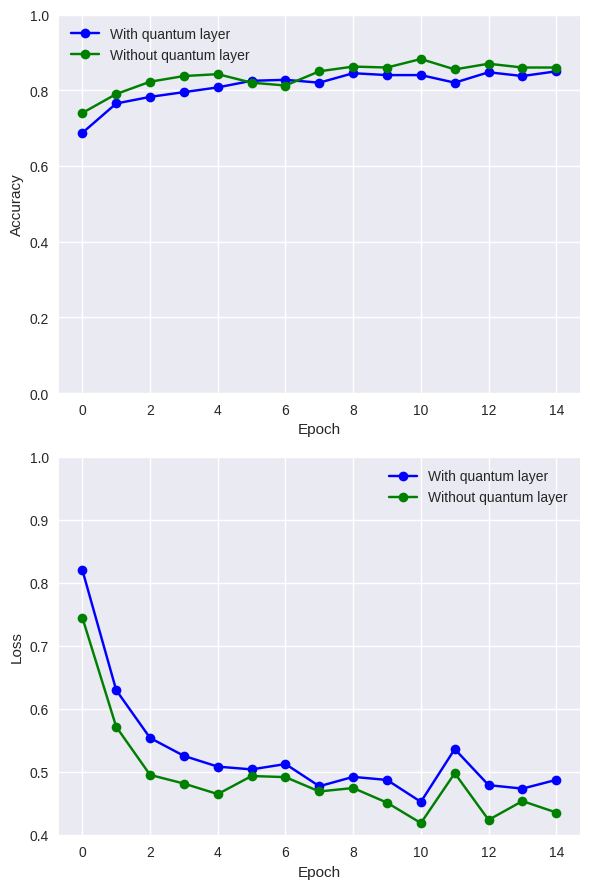

In [25]:
#accuracy and loss plot for with & without quantum layer

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=1)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

In [26]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [27]:
q_pred = q_model.predict(q_test_images)
q_pred_classes = np.argmax(q_pred, axis=1)

# Predicting with classical model
c_pred = c_model.predict(test_images)
c_pred_classes = np.argmax(c_pred, axis=1)


13/13 [==============================] - 1s 42ms/step


In [28]:
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

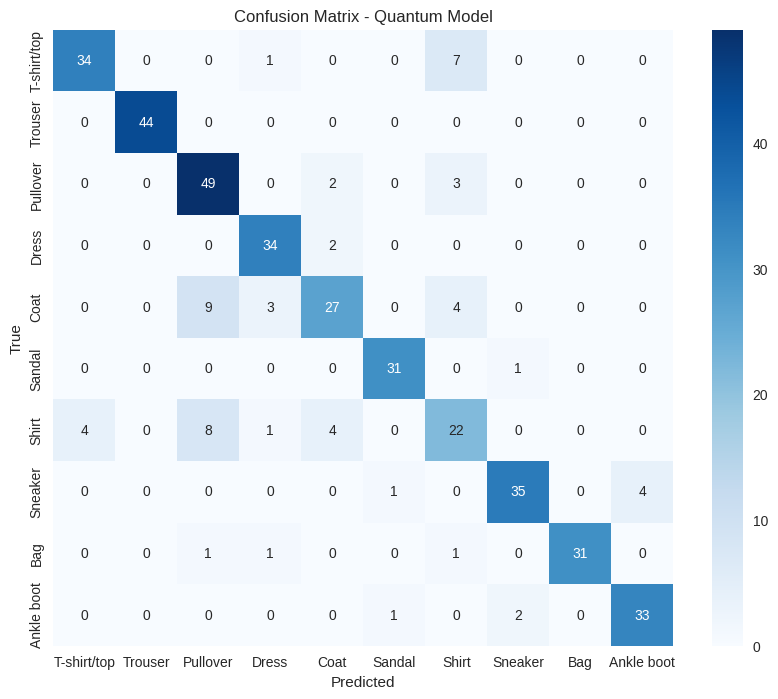

In [29]:
cm_q = confusion_matrix(test_labels, q_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_q, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Quantum Model')
plt.show()

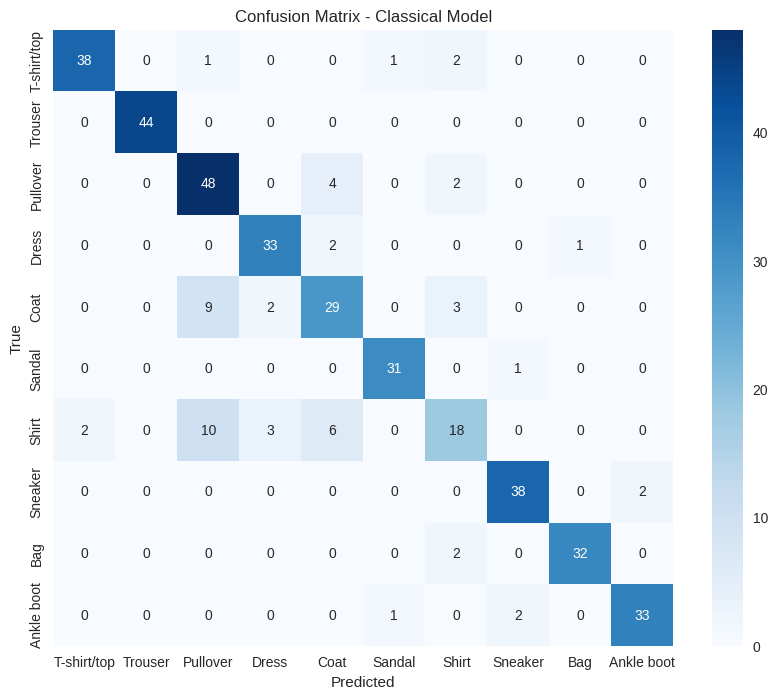

In [30]:
cm_c = confusion_matrix(test_labels, c_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_c, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Classical Model')
plt.show()

In [31]:
q_loss, q_accuracy = q_model.evaluate(q_test_images, test_labels, verbose=0)
print(f'Quantum Model Test Accuracy: {q_accuracy * 100:.2f}%')

# Evaluate the classical model on test data
c_loss, c_accuracy = c_model.evaluate(test_images, test_labels, verbose=0)
print(f'Classical Model Test Accuracy: {c_accuracy * 100:.2f}%')

Quantum Model Test Accuracy: 85.00%
Classical Model Test Accuracy: 86.00%
